In [2]:
# -*- coding: utf-8 -*-

import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn

from analyseIncrsTorchcuda import analyseIncrsTorchcuda_vp

import warnings
warnings.filterwarnings("ignore")

In [3]:
# Definition of the scales of analysis
nv=10
uu=2**np.arange(0,13,1/nv)
scales=np.unique(uu.astype(int))
scales=scales[0:100]

In [4]:
#%% The model NN-Turb
cuda = True if torch.cuda.is_available() else False
dev = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class CNNGenerator(nn.Module):
    def __init__(self):
        super().__init__()
        # The input of my generator is a noise of size (2048,1)
        # The output of my generator is a signal of size (2048,1)
        self.avgpool = nn.AvgPool1d(2, ceil_mode=False)
        self.avgpoolc = nn.AvgPool1d(2, ceil_mode=True)
        self.upsample = nn.Upsample(scale_factor=2, mode='linear')
        self.cnn1 = nn.Sequential( 
            nn.Conv1d(1, 16, kernel_size = 1, stride = 1, padding = 0, bias = False),
            nn.BatchNorm1d(16),
            nn.ReLU(True),
            )
        self.cnn2 = nn.Sequential(
            nn.Conv1d(16, 32, kernel_size = 2, stride = 1, padding = 0, bias = False),
            nn.BatchNorm1d(32),
            nn.ReLU(True),
            )
        self.cnn4 = nn.Sequential(
            nn.Conv1d(32, 64, kernel_size = 4, stride = 1, padding = 0, bias = False),
            nn.BatchNorm1d(64),
            nn.ReLU(True),
            )
        self.cnn8 = nn.Sequential(
            nn.Conv1d(64, 128, kernel_size = 8, stride = 1, padding = 0, bias = False),
            nn.BatchNorm1d(128),
            nn.ReLU(True),
            )
        self.cnn16 = nn.Sequential(
            nn.Conv1d(128, 256, kernel_size = 16, stride = 1, padding = 0, bias = False),
            nn.BatchNorm1d(256),
            nn.ReLU(True),
            )
        self.cnn32 = nn.Sequential(
            nn.Conv1d(256, 256, kernel_size = 32, stride = 1, padding = 0, bias = False),
            nn.BatchNorm1d(256),
            nn.ReLU(True),
            )
        self.cnn64 = nn.Sequential(
            nn.Conv1d(256, 256, kernel_size = 64, stride = 1, padding = 0, bias = False),
            nn.BatchNorm1d(256),
            nn.ReLU(True),
            )
        self.cnntrans64 = nn.Sequential(
            nn.ConvTranspose1d(256, 256, kernel_size = 64, stride = 1, padding = 0, bias = False),
            nn.BatchNorm1d(256),
            nn.ReLU(True),
            )
        self.cnntrans32 = nn.Sequential(
            nn.ConvTranspose1d(256, 256, kernel_size = 32, stride = 1, padding = 0, bias = False),
            nn.BatchNorm1d(256),
            nn.ReLU(True),
            )
        self.cnntrans16 = nn.Sequential(
            nn.ConvTranspose1d(256, 128, kernel_size = 16, stride = 1, padding = 0, bias = False),
            nn.BatchNorm1d(128),
            nn.ReLU(True),
            )
        self.cnntrans8 = nn.Sequential(
            nn.ConvTranspose1d(128, 64, kernel_size = 8, stride = 1, padding = 0, bias = False),
            nn.BatchNorm1d(64),
            nn.ReLU(True),
            )
        self.cnntrans4 = nn.Sequential(
            nn.ConvTranspose1d(64, 32, kernel_size = 4, stride = 1, padding = 0, bias = False),
            nn.BatchNorm1d(32),
            nn.ReLU(True),
            )
        self.cnntrans2 = nn.Sequential(
            nn.ConvTranspose1d(32, 16, kernel_size = 2, stride = 1, padding = 0, bias = False),
            nn.BatchNorm1d(16),
            nn.ReLU(True),
            )
        self.cnntrans1 = nn.Sequential(
            nn.ConvTranspose1d(16, 1, kernel_size = 1, stride = 1, padding = 0, bias = False),
            )
        self.bridge1 = nn.Sequential(
            nn.Conv1d(256, 256, kernel_size = 64, stride = 1, padding = 0, bias = False),
            nn.BatchNorm1d(256),
            nn.ReLU(True),
            )
        self.bridge2 = nn.Sequential(
            nn.Conv1d(256, 256, kernel_size = 128, stride = 1, padding = 0, bias = False),
            nn.BatchNorm1d(256),
            nn.ReLU(True),
            )
        self.bridge3 = nn.Sequential(
            nn.ConvTranspose1d(256, 256, kernel_size = 128, stride = 1, padding = 0, bias = False),
            nn.BatchNorm1d(256),
            nn.ReLU(True),
            )
        self.bridge4 = nn.Sequential(
            nn.ConvTranspose1d(256, 256, kernel_size = 64, stride = 1, padding = 0, bias = False),
            nn.BatchNorm1d(256),
            nn.ReLU(True),
            )
        
    def forward(self, z):    
        residual1  = self.cnn1(z)
        out = residual1 #= out->  size
        
        residual2  = self.cnn2(out)
        out = residual2 
        out = self.avgpoolc(out)#= out ->size/2
        
        residual4  = self.cnn4(out)
        out = residual4 
        out = self.avgpoolc(out)#= out ->size/4
        
        residual8  = self.cnn8(out)
        out = residual8 
        out = self.avgpoolc(out) #= out -> size=8
        
        residual16  = self.cnn16(out)
        out = residual16 
        out = self.avgpoolc(out) #= out -> size/16
        
        residual32  = self.cnn32(out)
        out = residual32 
        out = self.avgpoolc(out) #= out -> size/32
        
        out  = self.cnn64(out)
        
        #Bridge
        out = self.bridge1(out)
        out = self.bridge4(out)
        #End of Bridge
        
        out  = self.cnntrans64(out)
        out = self.upsample(out)
        out = out + residual32 # -> size/16
        
        out  = self.cnntrans32(out)
        out  =self.upsample(out)
        out = out[:,:,0:-1] + residual16 # -> size/8
        
        out  = self.cnntrans16(out)
        out  =self.upsample(out)
        out  = out + residual8 #-> size/4

        out  = self.cnntrans8(out)
        out  =self.upsample(out)
        out  = out[:,:,0:-1] + residual4 #-> size/2

        out  = self.cnntrans4(out)
        out  =self.upsample(out)
        out  = out[:,:,0:-1] + residual2 #-> size

        out  = self.cnntrans2(out)
        out  = out + residual1 #->size

        out  = self.cnntrans1(out)
        return out

We use NN-Turb model to generate $nb$ realizations of size $Nts$ of our stochastic 1D field.

In [18]:
#Turbulent velocity field generation

# Parameters for 1D field generation:
Nts=2**15+8192 # Size of generated field
nb = 16 # Number of realizations
ii=4096 # The statistics are done fom sample ii
ee=-4096 # The statistics are done until sample ee --> ee must be higher than ii
#------------------------------------

# We load the model
PATH='NN-Turb.pt'
checkpoint = torch.load(PATH,map_location=torch.device('cpu'))

generator = CNNGenerator()
generator.load_state_dict(checkpoint['model_state_dict'])
generator.eval()

# We generate the Gaussian white noise used as input
z = torch.randn((nb, 1, Nts), device=dev)

# We generate synthetic trajectories
with torch.no_grad():
    generated = generator(z)

mouv=torch.cumsum(generated,dim=2)
mouv=torch.flip(mouv,dims=[2])

# Normalization of the stochastic field
mouv=(mouv[:,:,ii:ee]-torch.mean(mouv[:,:,ii:ee], dim=2, keepdim=True)/torch.std(mouv[:,:,ii:ee], dim=2,keepdim=True))

# Estimations of second order structure function, skewness and flatness
sgenerated=analyseIncrsTorchcuda_vp(mouv,scales, dev).to(dev)

We convert torch tensors into numpy arrays for plots. We also define some important variables for figures generation.

In [19]:
mouv=mouv.cpu().detach().numpy()
# Size of generated field
N=mouv.shape[2]

# integral and dissipative scales of the generated field
L=2375
eta=5

# Font sizes for figures
fs=18
ts=18

We plot some realizations of the 1D field generated with NN-Turb model:

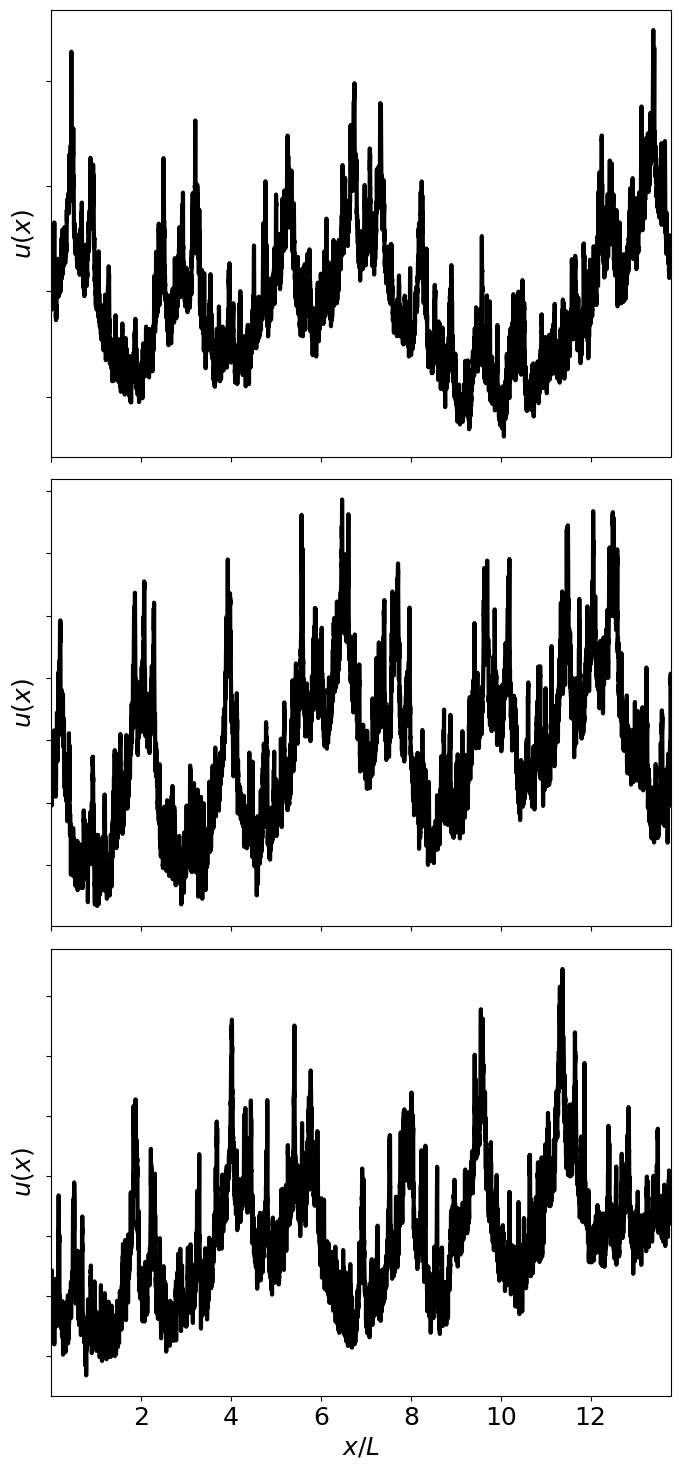

In [20]:
# Parameters for figure 1 plot
i1=0 # Realizations to show in figure 2
i2=1 # Realizations to show in figure 2
i3=2 # Realizations to show in figure 2
#------------------------------------

# Figure 1
fig, ax = plt.subplots(3, 1, figsize=(8, 18))
fig.subplots_adjust(wspace=0.25, hspace=0.05)

# sub1
ax[0].plot(np.arange(N)/L, mouv[i1,0,:], color='k', linestyle='-', linewidth=3)
#ax[0].hlines(2.5,L*5/L,L*5/L+L/L,color='b',linestyle='-', linewidth=6)
#ax[0].hlines(-2.5,L*5/L,L*5/L+L/L,color='b',linestyle='-', linewidth=6)
#ax[0].vlines(L*5/L,-2.5,2.5,color='b',linestyle='-', linewidth=6)
#ax[0].vlines(L*5/L+L/L,-2.5,2.5,color='b',linestyle='-', linewidth=6)
ax[0].set_xlim(0,N/L)
ax[0].set_xticklabels([])
ax[0].set_ylabel(r'$u(x)$', fontsize=fs)
#ax[0].text(2000/L,4,'a)', fontsize=fs)
ax[0].tick_params(labelsize=ts)
ax[0].set_yticklabels([])

# sub2
ax[1].plot(np.arange(N)/L, mouv[i2,0,:], color='k', linestyle='-', linewidth=3)
#ax[1].hlines(3,L*5/L,L*5/L+L/L,color='b',linestyle='-', linewidth=6)
#ax[1].hlines(-2,L*5/L,L*5/L+L/L,color='b',linestyle='-', linewidth=6)
#ax[1].vlines(L*5/L,-2,3,color='b',linestyle='-', linewidth=6)
#ax[1].vlines(L*5/L+L/L,-2,3,color='b',linestyle='-', linewidth=6)#ax[1].set_ylim(-4,4)
ax[1].set_xlim(0,N/L)
ax[1].set_xticklabels([])
ax[1].set_ylabel(r'$u(x)$', fontsize=fs)
#ax[1].text(2000/L,4,'b)', fontsize=fs)
ax[1].tick_params(labelsize=ts)
ax[1].set_yticklabels([])


# sub3
ax[2].plot(np.arange(N)/L, mouv[i3,0,:], color='k', linestyle='-', linewidth=3)
#ax[2].hlines(2,L*5/L,L*5/L+L/L,color='b',linestyle='-', linewidth=6)
#ax[2].hlines(-3,L*5/L,L*5/L+L/L,color='b',linestyle='-', linewidth=6)
#ax[2].vlines(L*5/L,-3,2,color='b',linestyle='-', linewidth=6)
#ax[2].vlines(L*5/L+L/L,-3,2,color='b',linestyle='-', linewidth=6)
ax[2].set_xlim(0,N/L)
ax[2].set_ylabel(r'$u(x)$', fontsize=fs)
ax[2].set_xlabel(r'$x/L$', fontsize=fs)
#ax[2].text(2000/L,3,'c)', fontsize=fs)
ax[2].tick_params(labelsize=ts)
ax[2].set_yticklabels([])
ax[2].set_xticks([2,4,6,8,10,12])
ax[2].set_xticklabels(['2','4','6','8','10','12'])

plt.show()

We plot the second order structure function, the skewness and the flatness across scales

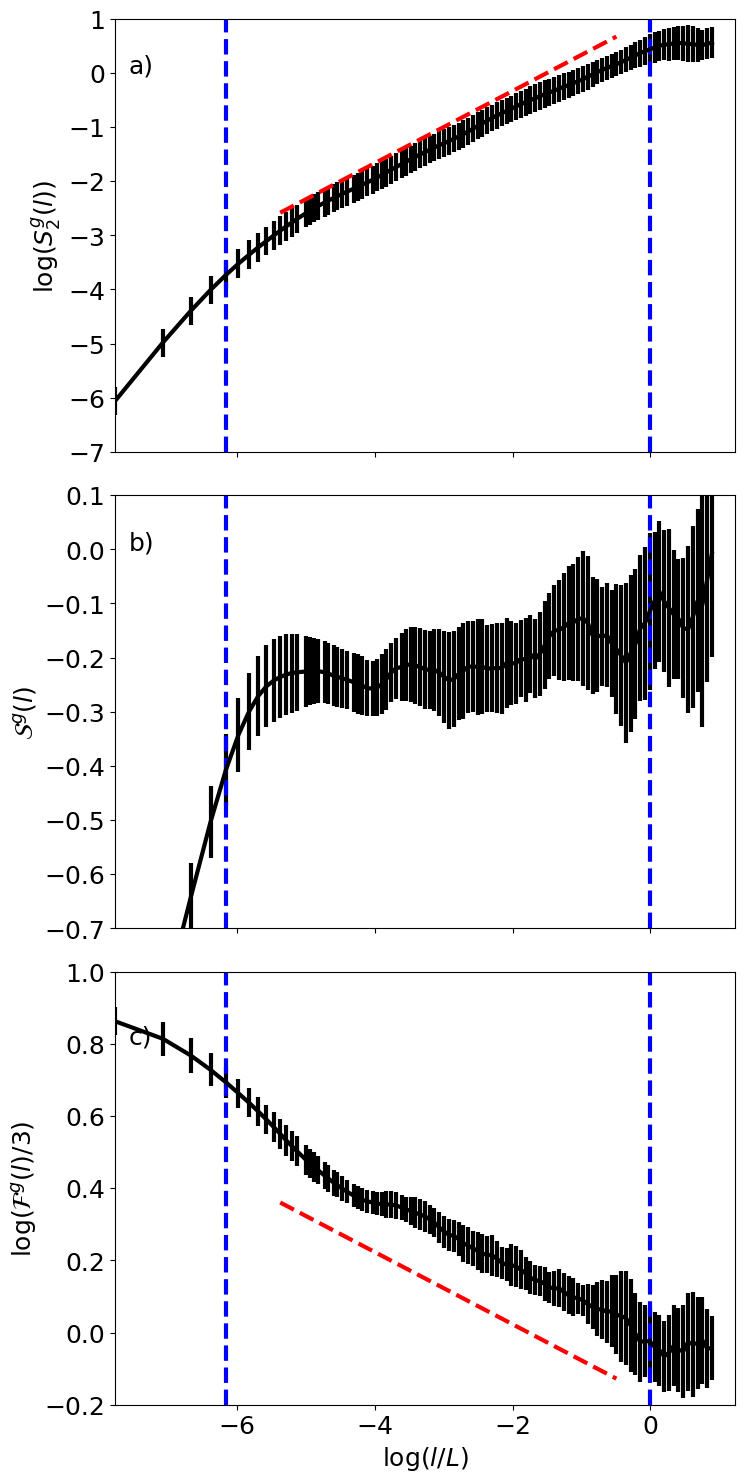

In [12]:
sgenerated=sgenerated.cpu().detach().numpy()

# Figure 2
fig, ax = plt.subplots(3, 1, figsize=(8, 18))
fig.subplots_adjust(wspace=0.25, hspace=0.1)

# sub1 S2
img1=ax[0].errorbar(np.log(scales/L),np.mean(sgenerated[:,0,:],axis=0),np.std(sgenerated[:,0,:],axis=0),color='k', linewidth=3)
ax[0].plot(np.log(scales[10:-20]/L), 2/3 * np.log(scales[10:-20]/L)+1,color='r', linestyle='--', linewidth=3)
ax[0].set_ylim(-7,1)
ax[0].set_xlim(0-np.log(L),9-np.log(L))
ax[0].set_xticklabels([])
ax[0].set_ylabel(r'$\log(S^g_2(l))$', fontsize=fs)
ax[0].text(0.2-np.log(L),0,'a)', fontsize=fs)
ax[0].tick_params(labelsize=ts)
ax[0].vlines(np.log(L/L),-7,1,color='b',linestyle='--', linewidth=3)
ax[0].vlines(np.log(eta/L),-7,1,color='b',linestyle='--', linewidth=3)

# sub2 Skew
img2=ax[1].errorbar(np.log(scales/L),np.mean(sgenerated[:,1,:],axis=0),np.std(sgenerated[:,1,:],axis=0),color='k', linewidth=3)
ax[1].set_ylim(-0.7,0.1)
ax[1].set_xlim(0-np.log(L),9-np.log(L))
ax[1].set_xticklabels([])
ax[1].set_ylabel(r'$\mathcal{S}^g(l)$', fontsize=fs)
ax[1].text(0.2-np.log(L),0,'b)', fontsize=fs)
ax[1].tick_params(labelsize=ts)
ax[1].vlines(np.log(L/L),-0.7,0.1,color='b',linestyle='--', linewidth=3)
ax[1].vlines(np.log(eta/L),-0.7,0.1,color='b',linestyle='--', linewidth=3)

# sub3 Flat
img3=ax[2].errorbar(np.log(scales/L),np.mean(np.log(sgenerated[:,2,:]),axis=0),np.std(np.log(sgenerated[:,2,:]),axis=0),color='k', linewidth=3)
ax[2].plot(np.log(scales[10:-20]/L), -0.1 * np.log(scales[10:-20])+0.6,color='r', linestyle='--', linewidth=3)
ax[2].set_ylim(-0.2,1)
ax[2].set_xlim(0-np.log(L),9-np.log(L))
ax[2].set_ylabel(r'$\log(\mathcal{F}^g(l)/3)$', fontsize=fs)
ax[2].set_xlabel(r'$\log(l/L)$', fontsize=fs)
ax[2].text(0.2-np.log(L),0.8,'c)', fontsize=fs)
ax[2].tick_params(labelsize=ts)
ax[2].vlines(np.log(L/L),-0.2,1,color='b',linestyle='--', linewidth=3)
ax[2].vlines(np.log(eta/L),-0.2,1,color='b',linestyle='--', linewidth=3)

plt.show()

We plot the histogram of some increments of different sizes from the dissipative to the integral domain.

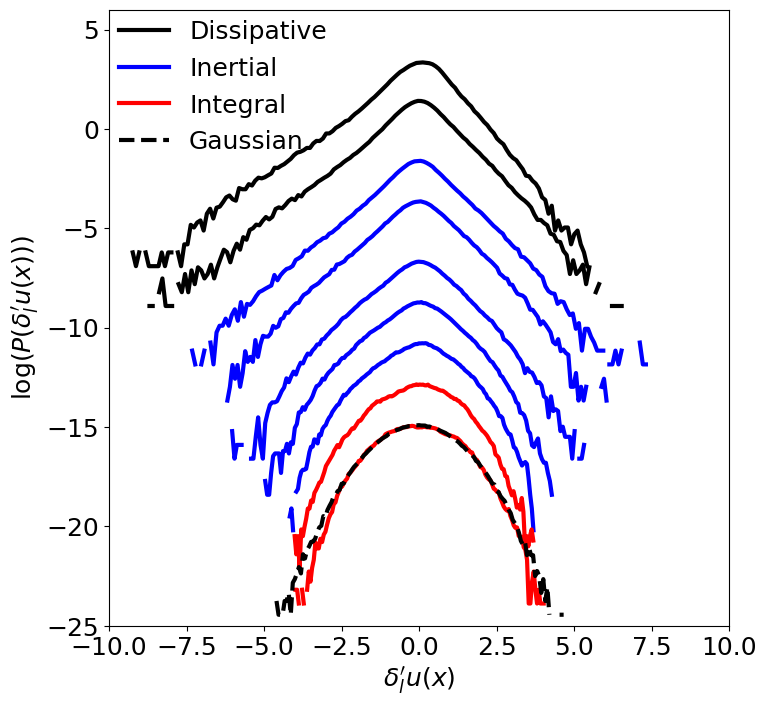

In [17]:
#%% Figure 3

# Parameters for figure 3 plot
bb=150 # Number of bins in histogram
#------------------------------------

# Generation of increments of different sizes
yy=np.squeeze(mouv[:,0,:])

scale=2
incrs2=yy[:,scale:]-yy[:,:-scale]
scale=4
incrs4=yy[:,scale:]-yy[:,:-scale]
scale=8
incrs8=yy[:,scale:]-yy[:,:-scale]
scale=16
incrs16=yy[:,scale:]-yy[:,:-scale]
scale=64
incrs64=yy[:,scale:]-yy[:,:-scale]
scale=256
incrs256=yy[:,scale:]-yy[:,:-scale]
scale=1024
incrs1024=yy[:,scale:]-yy[:,:-scale]
scale=4096
incrs4096=yy[:,scale:]-yy[:,:-scale]
scale=10000
incrs10000=yy[:,scale:]-yy[:,:-scale]

# Normalization of increments
incrs2=(incrs2.T-np.mean(incrs2,axis=1))/np.std(incrs2,axis=1)
incrs4=(incrs4.T-np.mean(incrs4,axis=1))/np.std(incrs4,axis=1)
incrs8=(incrs8.T-np.mean(incrs8,axis=1))/np.std(incrs8,axis=1)
incrs16=(incrs16.T-np.mean(incrs16,axis=1))/np.std(incrs16,axis=1)
incrs64=(incrs64.T-np.mean(incrs64,axis=1))/np.std(incrs64,axis=1)
incrs256=(incrs256.T-np.mean(incrs256,axis=1))/np.std(incrs256,axis=1)
incrs1024=(incrs1024.T-np.mean(incrs1024,axis=1))/np.std(incrs1024,axis=1)
incrs4096=(incrs4096.T-np.mean(incrs4096,axis=1))/np.std(incrs4096,axis=1)
incrs10000=(incrs10000.T-np.mean(incrs10000,axis=1))/np.std(incrs10000,axis=1)

# Histogram
histi2, bins2=np.histogram(incrs2.flatten(), bins=bb, density=True)
histi4, bins4=np.histogram(incrs4.flatten(), bins=bb, density=True)
histi8, bins8=np.histogram(incrs8.flatten(), bins=bb, density=True)
histi16, bins16=np.histogram(incrs16.flatten(), bins=bb, density=True)
histi64, bins64=np.histogram(incrs64.flatten(), bins=bb, density=True)
histi256, bins256=np.histogram(incrs256.flatten(), bins=bb, density=True)
histi1024, bins1024=np.histogram(incrs1024.flatten(), bins=bb, density=True)
histi4096, bins4096=np.histogram(incrs4096.flatten(), bins=bb, density=True)
histi10000, bins10000=np.histogram(incrs10000.flatten(), bins=bb, density=True)

# Centered and Standardized Gaussian histogram
xgn=np.random.randn(nb*N)
histgn, binsgn=np.histogram(xgn, bins=bb, density=True)

# Figure 3
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

# sub1 S2
line1,=plt.plot(bins2[0:-1],4+np.log(histi2), 'k', linewidth=3)
plt.plot(bins4[0:-1],2+np.log(histi4), 'k', linewidth=3)
line2,=plt.plot(bins8[0:-1],-1+np.log(histi8), 'b', linewidth=3)
plt.plot(bins16[0:-1],-3+np.log(histi16), 'b', linewidth=3)
plt.plot(bins64[0:-1],-6+np.log(histi64), 'b', linewidth=3)
plt.plot(bins256[0:-1],-8+np.log(histi256), 'b', linewidth=3)
plt.plot(bins1024[0:-1],-10+np.log(histi1024), 'b', linewidth=3)
line3,=plt.plot(bins4096[0:-1],-12+np.log(histi4096), 'r', linewidth=3)
plt.plot(bins10000[0:-1],-14+np.log(histi10000), 'r', linewidth=3)
line4,=plt.plot(binsgn[0:-1],-14+np.log(histgn),'k--',linewidth=3)
plt.xlim(-10,10)
plt.ylim(-25,6)
plt.legend([line1,line2,line3,line4],['Dissipative','Inertial','Integral','Gaussian'], loc=[0.0 , 0.75], fontsize=fs, frameon=False)
plt.ylabel(r'$\log(P(\delta^{\prime}_l u(x)))$', fontsize=fs)
plt.xlabel(r'$\delta^{\prime}_l u(x)$', fontsize=fs)
plt.tick_params(labelsize=ts)

plt.show()